<center><b>Wall-Following Robot Navigation: Model Comparison and Analysis </b></center>

 <center>Moses Yehoshua | Ranjan Kumar | Jordan Glenn </center>

<center>Machine Learning (DS 675 - Spring 2025)</center>

<center>Professor Shuai Zhang</center>



Creating a comprehensive analysis of the Wall-Following Robot Navigation dataset from Kaggle, implementing multiple machine learning models and visualizing their performance with confusion matrices.

Data Link: https://www.kaggle.com/datasets/uciml/wall-following-robot/data


## System Overview

### Purpose

This document provides the design for a wall-following robot navigation system that uses sensor data to classify navigation behaviors. The system processes ultrasonic sensor readings and applies machine learning models to determine the optimal navigation action. We are creating a comprehensive analysis of the Wall-Following Robot Navigation dataset from Kaggle, implementing multiple machine learning models and visualizing their performance with confusion matrices.

### Scope

The design covers:

- Data acquisition from ultrasonic sensors
- Data preprocessing pipeline
- Model implementation and selection
- Inference engine
- Navigation control interface

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


## Dataset Overview

The Wall-Following Robot Navigation dataset contains sensor readings from a robot that follows walls. The robot uses ultrasonic sensors to detect distances to walls and is classified into different navigation behaviors.

In [ ]:

# Load the dataset
url = "/content/sensor_readings_24.data"
column_names = ['US1', 'US2', 'US3', 'US4', 'US5', 'US6', 'US7', 'US8',
                'US9', 'US10', 'US11', 'US12', 'US13', 'US14', 'US15',
                'US16', 'US17', 'US18', 'US19', 'US20', 'US21', 'US22',
                'US23', 'US24', 'class']
data = pd.read_csv(url, header=None, names=column_names)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US1     5456 non-null   float64
 1   US2     5456 non-null   float64
 2   US3     5456 non-null   float64
 3   US4     5456 non-null   float64
 4   US5     5456 non-null   float64
 5   US6     5456 non-null   float64
 6   US7     5456 non-null   float64
 7   US8     5456 non-null   float64
 8   US9     5456 non-null   float64
 9   US10    5456 non-null   float64
 10  US11    5456 non-null   float64
 11  US12    5456 non-null   float64
 12  US13    5456 non-null   float64
 13  US14    5456 non-null   float64
 14  US15    5456 non-null   float64
 15  US16    5456 non-null   float64
 16  US17    5456 non-null   float64
 17  US18    5456 non-null   float64
 18  US19    5456 non-null   float64
 19  US20    5456 non-null   float64
 20  US21    5456 non-null   float64
 21  US22    5456 non-null   float64
 22  

#Heatmap

<Axes: >

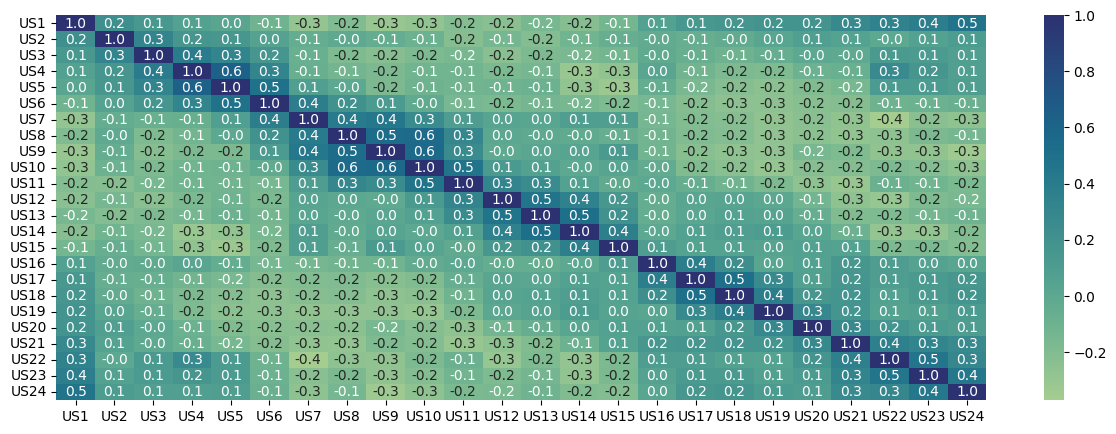

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data=data.drop(columns=['class']).corr() , annot=True,cmap="crest",fmt=".1f" )

class
Move-Forward         2205
Sharp-Right-Turn     2097
Slight-Right-Turn     826
Slight-Left-Turn      328
Name: count, dtype: int64


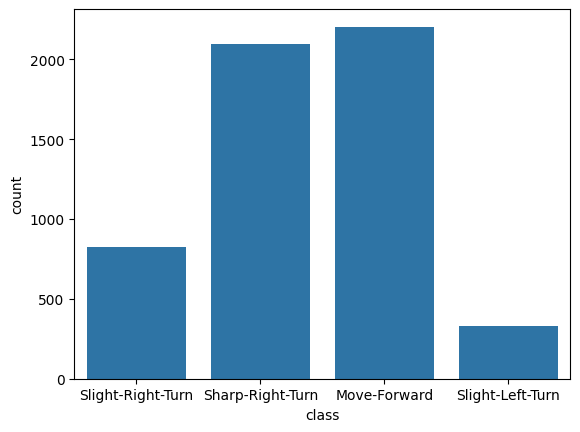

In [ ]:
ax = sns.countplot(x = "class",data=data, saturation=0.8)
plt.xticks(ticks=[0,1,2,3], labels = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn' ]) # Added commas between labels
print(data['class'].value_counts())
plt.show()

## Data Preprocessing

Let's preprocess the data for our machine learning models:
Transforms raw sensor data into a format suitable for model inference, including normalization, filtering, and feature extraction.
Loads trained machine learning models and performs inference on preprocessed sensor data to classify navigation behaviors.

In addition, we run a k-fold cross validation measure to enhance our model performance. We noticed that our 'class' variable is significantly imbalanced (slight-left turn only attributing to 6% of cases). Therefore, we run a 5-fold CV on separate subsets of the data.

In [ ]:

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Your existing class mapping
class_mapping = {
    'Slight-Right-Turn': 0,
    'Sharp-Right-Turn': 1,
    'Move-Forward': 2,
    'Slight-Left-Turn': 3
}

# Use the map function to encode the 'class' column
data['class'] = data['class'].map(class_mapping)

# Separate features (X) and target variable (y)
X = data.drop('class', axis=1)
y = data['class']

# First, create a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Setting up stratified k-fold cross-validation on the training set
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Store the fold indices for reuse across models
folds = list(skf.split(X_train_scaled, y_train))

print("Data preprocessing and cross-validation setup completed!")

Training set shape: (4364, 24)
Testing set shape: (1092, 24)
Data preprocessing and cross-validation setup completed!


## Model Implementation and Evaluation

Now, let's implement and evaluate multiple machine learning models:

1. Random Forest Classifier

In [ ]:
# Train Random Forest model
# Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform k-fold cross-validation
rf_fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(folds):
    # Get the data for this fold
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train the model
    rf_model.fit(X_fold_train, y_fold_train)

    # Evaluate on the validation fold
    y_fold_pred = rf_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    rf_fold_accuracies.append(fold_accuracy)
    print(f"Random Forest - Fold {fold+1} validation accuracy: {fold_accuracy:.4f}")

# Calculate average cross-validation accuracy
rf_cv_accuracy = np.mean(rf_fold_accuracies)
print(f"Random Forest - Average CV accuracy: {rf_cv_accuracy:.4f}")

# Train on the full training set and evaluate on test set
rf_model.fit(X_train_scaled, y_train)
y_test_pred = rf_model.predict(X_test_scaled)
rf_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Random Forest - Test accuracy: {rf_test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report (includes precision, recall, F1-score, support)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print feature importances (summary of the model)
print("\nFeature Importances:")
print(pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False))

# Permutation Feature Importance (PFI)
print("\nComputing Permutation Feature Importances...")
pfi_result = permutation_importance(
    rf_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Format and display permutation importances
perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_STD': pfi_result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Feature Importances (Test Set):")
print(perm_importances)

Random Forest - Fold 1 validation accuracy: 0.9908
Random Forest - Fold 2 validation accuracy: 0.9931
Random Forest - Fold 3 validation accuracy: 0.9908
Random Forest - Fold 4 validation accuracy: 0.9897
Random Forest - Fold 5 validation accuracy: 0.9977
Random Forest - Average CV accuracy: 0.9924
Random Forest - Test accuracy: 0.9954
Confusion Matrix:
[[163   2   0   0]
 [  0 419   1   0]
 [  1   0 440   0]
 [  0   0   1  65]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       165
           1       1.00      1.00      1.00       420
           2       1.00      1.00      1.00       441
           3       1.00      0.98      0.99        66

    accuracy                           1.00      1092
   macro avg       1.00      0.99      0.99      1092
weighted avg       1.00      1.00      1.00      1092


Feature Importances:
   Feature  Importance
14    US15    0.266337
18    US19    0.112008
13    US14    0.09

2. Support Vector Machine (SVM)

In [ ]:

# Define the model
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

# Perform k-fold cross-validation
svm_fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(folds):
    # Get the data for this fold
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train the model
    svm_model.fit(X_fold_train, y_fold_train)

    # Evaluate on the validation fold
    y_fold_pred = svm_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    svm_fold_accuracies.append(fold_accuracy)
    print(f"SVM - Fold {fold+1} validation accuracy: {fold_accuracy:.4f}")

# Calculate average cross-validation accuracy
svm_cv_accuracy = np.mean(svm_fold_accuracies)
print(f"SVM - Average CV accuracy: {svm_cv_accuracy:.4f}")

# Train on the full training set and evaluate on test set
svm_model.fit(X_train_scaled, y_train)
y_test_pred = svm_model.predict(X_test_scaled)
svm_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"SVM - Test accuracy: {svm_test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report (includes precision, recall, F1-score, support)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print feature importances (summary of the model)
print("\nFeature Importances:")
print(pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False))

# Permutation Feature Importance (PFI) — only way to get feature importance for SVM
print("\nComputing Permutation Feature Importances (SVM)...")
pfi_result = permutation_importance(
    svm_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Format and display permutation importances
perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_STD': pfi_result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Feature Importances (SVM - Test Set):")
print(perm_importances)

SVM - Fold 1 validation accuracy: 0.9152
SVM - Fold 2 validation accuracy: 0.9152
SVM - Fold 3 validation accuracy: 0.9084
SVM - Fold 4 validation accuracy: 0.9187
SVM - Fold 5 validation accuracy: 0.9140
SVM - Average CV accuracy: 0.9143
SVM - Test accuracy: 0.9267
Confusion Matrix:
[[150   3  12   0]
 [  8 397  12   3]
 [ 10  26 404   1]
 [  0   1   4  61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       165
           1       0.93      0.95      0.94       420
           2       0.94      0.92      0.93       441
           3       0.94      0.92      0.93        66

    accuracy                           0.93      1092
   macro avg       0.92      0.92      0.92      1092
weighted avg       0.93      0.93      0.93      1092


Feature Importances:
   Feature  Importance
14    US15    0.266337
18    US19    0.112008
13    US14    0.090912
19    US20    0.085694
17    US18    0.074182
12    US13    0.057

3. K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance


# Define the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Perform k-fold cross-validation
knn_fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(folds):
    # Get the data for this fold
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train the model
    knn_model.fit(X_fold_train, y_fold_train)

    # Evaluate on the validation fold
    y_fold_pred = knn_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    knn_fold_accuracies.append(fold_accuracy)
    print(f"KNN - Fold {fold+1} validation accuracy: {fold_accuracy:.4f}")

# Calculate average cross-validation accuracy
knn_cv_accuracy = np.mean(knn_fold_accuracies)
print(f"KNN - Average CV accuracy: {knn_cv_accuracy:.4f}")

# Train on the full training set and evaluate on test set
knn_model.fit(X_train_scaled, y_train)
y_test_pred = knn_model.predict(X_test_scaled)
knn_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"KNN - Test accuracy: {knn_test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report (includes precision, recall, F1-score, support)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print feature importances (summary of the model)
print("\nFeature Importances:")
print(pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False))

# Permutation Feature Importance (PFI)
print("\nComputing Permutation Feature Importances (KNN)...")
pfi_result = permutation_importance(
    knn_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create a DataFrame with feature names and importances
perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_STD': pfi_result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Feature Importances (KNN - Test Set):")
print(perm_importances)


KNN - Fold 1 validation accuracy: 0.8373
KNN - Fold 2 validation accuracy: 0.8477
KNN - Fold 3 validation accuracy: 0.8167
KNN - Fold 4 validation accuracy: 0.8442
KNN - Fold 5 validation accuracy: 0.8555
KNN - Average CV accuracy: 0.8403
KNN - Test accuracy: 0.8553
Confusion Matrix:
[[140   7  18   0]
 [ 22 367  29   2]
 [ 21  43 367  10]
 [  0   3   3  60]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       165
           1       0.87      0.87      0.87       420
           2       0.88      0.83      0.86       441
           3       0.83      0.91      0.87        66

    accuracy                           0.86      1092
   macro avg       0.84      0.87      0.85      1092
weighted avg       0.86      0.86      0.86      1092


Feature Importances:
   Feature  Importance
14    US15    0.266337
18    US19    0.112008
13    US14    0.090912
19    US20    0.085694
17    US18    0.074182
12    US13    0.057

4. Neural Network (MLP)

In [ ]:
# Train Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50),
                         activation='relu',
                         solver='adam',
                         alpha=0.0001,
                         max_iter=300,
                         random_state=42)

# Perform k-fold cross-validation
nn_fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(folds):
    # Get the data for this fold
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train the model
    nn_model.fit(X_fold_train, y_fold_train)

    # Evaluate on the validation fold
    y_fold_pred = nn_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    nn_fold_accuracies.append(fold_accuracy)
    print(f"Neural Network - Fold {fold+1} validation accuracy: {fold_accuracy:.4f}")

# Calculate average cross-validation accuracy
nn_cv_accuracy = np.mean(nn_fold_accuracies)
print(f"Neural Network - Average CV accuracy: {nn_cv_accuracy:.4f}")

# Train on the full training set and evaluate on test set
nn_model.fit(X_train_scaled, y_train)
y_test_pred = nn_model.predict(X_test_scaled)
nn_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Neural Network - Test accuracy: {nn_test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report (includes precision, recall, F1-score, support)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print feature importances (summary of the model)
print("\nFeature Importances:")
print(pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False))

# Permutation Feature Importance (PFI) for MLP
print("\nComputing Permutation Feature Importances (Neural Network)...")
pfi_result = permutation_importance(
    nn_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create DataFrame with feature importances
perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_STD': pfi_result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Feature Importances (Neural Network - Test Set):")
print(perm_importances)

Neural Network - Fold 1 validation accuracy: 0.9175
Neural Network - Fold 2 validation accuracy: 0.9221
Neural Network - Fold 3 validation accuracy: 0.9049
Neural Network - Fold 4 validation accuracy: 0.9164
Neural Network - Fold 5 validation accuracy: 0.9243
Neural Network - Average CV accuracy: 0.9171
Neural Network - Test accuracy: 0.9295
Confusion Matrix:
[[152   4   9   0]
 [  6 398  15   1]
 [  9  22 407   3]
 [  0   2   6  58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       165
           1       0.93      0.95      0.94       420
           2       0.93      0.92      0.93       441
           3       0.94      0.88      0.91        66

    accuracy                           0.93      1092
   macro avg       0.93      0.92      0.92      1092
weighted avg       0.93      0.93      0.93      1092


Feature Importances:
   Feature  Importance
14    US15    0.266337
18    US19    0.112008
13    US14 

5. Decision Tree

In [ ]:

# Define the model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# Perform k-fold cross-validation
dt_fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(folds):
    # Get the data for this fold
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train the model
    dt_model.fit(X_fold_train, y_fold_train)

    # Evaluate on the validation fold
    y_fold_pred = dt_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    dt_fold_accuracies.append(fold_accuracy)
    print(f"Decision Tree - Fold {fold+1} validation accuracy: {fold_accuracy:.4f}")

# Calculate average cross-validation accuracy
dt_cv_accuracy = np.mean(dt_fold_accuracies)
print(f"Decision Tree - Average CV accuracy: {dt_cv_accuracy:.4f}")

# Train on the full training set and evaluate on test set
dt_model.fit(X_train_scaled, y_train)
y_test_pred = dt_model.predict(X_test_scaled)
dt_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree - Test accuracy: {dt_test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report (includes precision, recall, F1-score, support)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print feature importances (summary of the model)
print("\nFeature Importances:")
print(pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False))

# Built-in feature importances (from the trained Decision Tree)
print("\nFeature Importances (Gini-based):")
print(pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False))

# Permutation Feature Importance (PFI) — more robust
print("\nComputing Permutation Feature Importances (Decision Tree)...")
pfi_result = permutation_importance(
    dt_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_STD': pfi_result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Feature Importances (Decision Tree - Test Set):")
print(perm_importances)

Decision Tree - Fold 1 validation accuracy: 0.9954
Decision Tree - Fold 2 validation accuracy: 0.9966
Decision Tree - Fold 3 validation accuracy: 0.9863
Decision Tree - Fold 4 validation accuracy: 0.9931
Decision Tree - Fold 5 validation accuracy: 0.9989
Decision Tree - Average CV accuracy: 0.9940
Decision Tree - Test accuracy: 0.9945
Confusion Matrix:
[[163   1   1   0]
 [  1 418   1   0]
 [  1   1 439   0]
 [  0   0   0  66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       165
           1       1.00      1.00      1.00       420
           2       1.00      1.00      1.00       441
           3       1.00      1.00      1.00        66

    accuracy                           0.99      1092
   macro avg       0.99      0.99      0.99      1092
weighted avg       0.99      0.99      0.99      1092


Feature Importances:
   Feature  Importance
14    US15    0.266337
18    US19    0.112008
13    US14    0.09

## Model Comparison

Let's compare all the models to see which performs best:

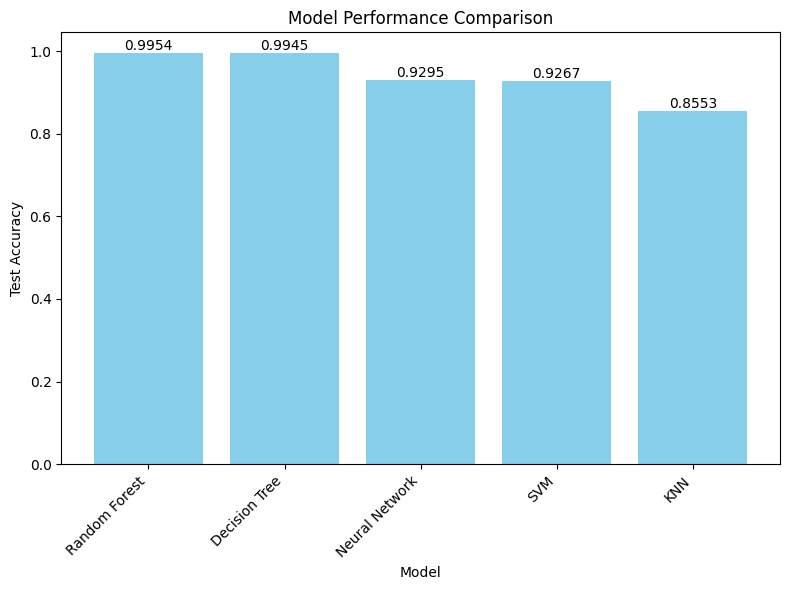

In [ ]:
# Test accuracy results (replace with your actual results)
model_names = ['Random Forest', 'SVM', 'KNN', 'Neural Network', 'Decision Tree']
test_accuracies = [rf_test_accuracy, svm_test_accuracy, knn_test_accuracy, nn_test_accuracy, dt_test_accuracy]

# Create a DataFrame for sorting
results_df = pd.DataFrame({'Model': model_names, 'Test Accuracy': test_accuracies})

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(results_df['Model'], results_df['Test Accuracy'], color='skyblue')

# Add data labels
for bar, accuracy in zip(bars, results_df['Test Accuracy']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{accuracy:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

This analysis demonstrates how different machine learning approaches can be applied to robot navigation problems, with each model offering different trade-offs between accuracy, interpretability, and computational complexity.

Reference  code: https://www.kaggle.com/code/ameerhassan22/wall-following-robot

Reference : https://v0.dev/chat/wall-following-robot-project-M14v6iyYc4h